In [2]:
import pandas as pd
import numpy as np
import torch 
import torch.nn as  nn
from torch.utils.data import TensorDataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.preprocessing import StandardScaler
import time
from tqdm.autonotebook import tqdm, trange
import matplotlib.pyplot as plt

device = 'cuda' if torch.cuda.is_available() else 'cpu'

/tmp/ipykernel_9345/2584037170.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [5]:
path = '~/Рабочий стол/ДИПЛОМ НОУТБУКИ/DL forcasitng diplom/Данные Мосбиржа/ДНЕВНЫЕ_ДАННЫЕ_МОСБИРЖА.txt'
total_df = pd.read_csv(path, sep=';')

In [16]:
data = np.array( total_df[total_df['<TICKER>'] == 'ЛУКОЙЛ']['<CLOSE>'] )

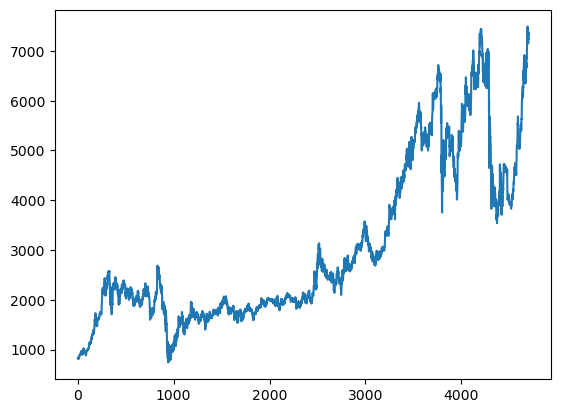

In [260]:
plt.plot(data)

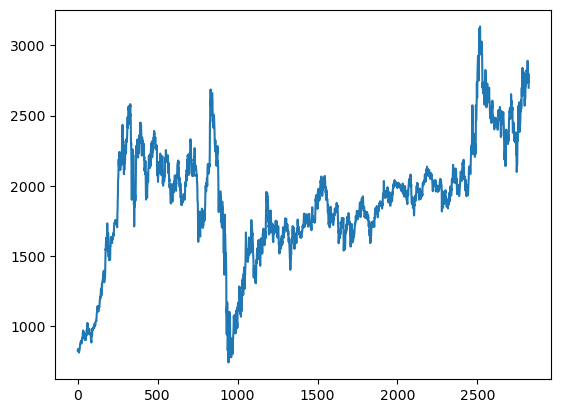

In [261]:
train_data = data[ : round(data.shape[0]*0.60) ]
plt.plot(train_data)

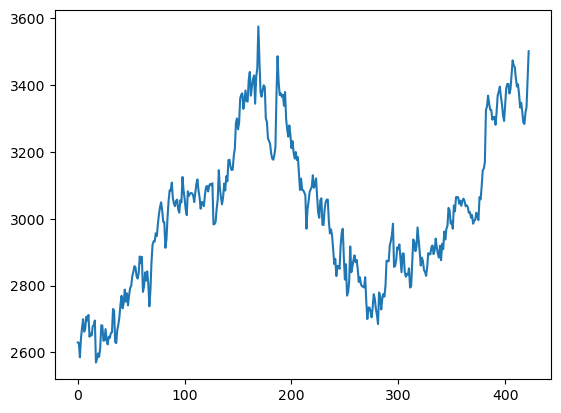

In [262]:
val_data = data[round(data.shape[0]*0.60) : round(data.shape[0]*0.69) ]
plt.plot(val_data)

In [263]:
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data.reshape(-1,1))
val_data = scaler.transform(val_data.reshape(-1,1))

In [264]:
def sample_creator(df, lookback, horizon):
    """
    Функция нарезает данные скользящим окном, 
    lookback=исторический промежуток
    horizon=горизонт прогнозирования
    !Внимание! target переменная должна стоять в первом столбце!
    """
    X = []
    Y = np.array([np.zeros(horizon) for i in range(lookback, df.shape[0]-horizon+1 )])
    
    for i in range(lookback, df.shape[0]-horizon+1):
        x = df[i-lookback : i, :]
        X.append(x)
        y = df[i:i+horizon, 0]
        Y[i-lookback] += y
        
        
    X = torch.Tensor(np.array(X))
    Y = torch.Tensor(Y)
    return X, Y

In [265]:
lookback = 30
horizon = 1

x_train, y_train = sample_creator(train_data, lookback, horizon)
x_val, y_val = sample_creator(val_data, lookback, horizon)

print(f'x_train: {x_train.shape}, y_train: {y_train.shape}\nx_val: {x_val.shape}, y_val: {y_val.shape}')

x_train: torch.Size([2792, 30, 1]), y_train: torch.Size([2792, 1])
x_val: torch.Size([393, 30, 1]), y_val: torch.Size([393, 1])


In [438]:
train_dataset = TensorDataset(x_train, y_train)
val_dataset  = TensorDataset(x_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=150, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=150, shuffle=False)

In [439]:
def winrate(y_true, y_pred):
    '''
    Входной формат: BatchSize*horizon(1)
    Выводит усреднённое число угаданных направлений по всему горизонту прогнозирования
    и всем батчам.
    Если горизонт = 1, то просто усредняет по батчам 
    '''
    
    diff_pred_vec = np.sign(np.diff(y_pred))
    diff_true_vec = np.sign(np.diff(y_true))
    res = np.where( diff_true_vec == diff_pred_vec , 1, 0).sum() / diff_true_vec.size
    return res

<!-- class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, dropout, fcst_horizon=1):
        '''
        LSTM с последующим дропаутом и двумя линейными слоями
        input_size: кол-во фичей(или совместно подаваемых рядов)
        hidden_size: внутренняя размерность каналов краткосрочной и долговсрочной памяти
        num_layers: количество LSTM слоёв
        dropout: коэффициент dropout
        fcst_horizon: длина горизонта прогнозировния
        '''
        super(LSTMModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout
        self.fcst_horizon = fcst_horizon
        
        self.lstm = nn.LSTM(input_size=self.input_size, 
                            hidden_size=self.hidden_size,
                            num_layers=self.num_layers,
                            batch_first=True)
        self.dropout = nn.Dropout(self.dropout)
        self.fc1 = nn.Linear(self.hidden_size, 32)
        self.fc2 = nn.Linear(32, self.fcst_horizon)

    def forward(self, x):
        x, _ = self.lstm(x) # Prediction и логи долгосрочной памяти( x.shape = (B, len_seq, hidden_size))
        x = self.dropout(x[:,-1,:])# Отбираем в B матрицах размера (len_seq,hidden_size) только последние вектора
        x = self.fc1(x) #Постепенно из 64 мерного пространства сводим в 1 мерное
        x = self.fc2(x) #Постепенно из 64 мерного пространства сводим в 1 мерное
        return x -->

In [471]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model) #zero matriz of shape (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1) #arange vector of shape (max_len,1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)
    
class TransformerModel(nn.Module):
    '''
    input_dim: Token dim(=1 так используем только информацию о цене закрытия)
    d_model: (EBMEDDING SIZE)
    nhead: Кол-во Single attention heads в Multihead слое
    num_layers: Количество Encoder блоков в слое 
    dropout: The dropout probability.
    '''
    def __init__(self, input_dim=1, d_model=256, nhead=4, num_layers=3, dropout=0.1):
        super(TransformerModel, self).__init__()

        self.ebedder = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.head = nn.Linear(d_model, 1)
    
    def forward(self, x):
        x = self.ebedder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.head(x[:, -1, :])  
        return x    

In [472]:
model = TransformerModel().to(device)

In [473]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-6)
scheduler = ReduceLROnPlateau(optimizer, 'min', factor=0.2, patience=3, verbose=True)

epochs = 400
early_stop_count = 0
min_val_loss = float('inf')

train_loss_per_epoch = []
val_loss_per_epoch = []
train_winrate = []
val_winrate = []



pbar = trange(epochs, desc="Epoch:")
since = time.time()

for epoch in pbar:
    model.train()
    train_losses = 0
    train_win = 0
    for batch in tqdm(train_loader, leave=False, desc="Train iter:"):
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        train_losses += loss.item()
        optimizer.step()
        train_loss = train_losses/len(train_loader)
        train_win += winrate(y_batch.reshape(-1,).cpu().detach(), outputs.reshape(-1,).cpu().detach())
    train_loss_per_epoch.append(train_loss)    
    train_winrate.append(train_win / len(train_loader))
    
    # Validation
    model.eval()
    val_losses = 0
    val_win = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, leave=False, desc="Val iter:"):
            x_batch, y_batch = batch
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            val_losses += loss.item()
            val_win += winrate(y_batch.reshape(-1,).cpu().detach(), outputs.reshape(-1,).cpu().detach())
    val_loss = val_losses/len(val_loader)
    val_loss_per_epoch.append(val_loss)
    val_winrate.append(val_win / len(val_loader))
    
    scheduler.step(val_loss)
    if val_loss < 0.0001:
        torch.save(model.state_dict(), f'ВЕСА/(1blocks)TSMixer(M F=TI) 1D|W={val_win / len(val_loader)}, VL={val_loss}' )
    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 15:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}","/",f"{epochs},Train Loss: {train_loss:.6f} Validation Loss: {val_loss:.6f}")
time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    

Epoch::   0%|          | 0/400 [00:00<?, ?it/s]

Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 1 / 400,Train Loss: 1.798353 Validation Loss: 10.774652


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 2 / 400,Train Loss: 1.588841 Validation Loss: 9.716078


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 3 / 400,Train Loss: 1.448603 Validation Loss: 8.770683


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 4 / 400,Train Loss: 1.292334 Validation Loss: 7.940609


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 5 / 400,Train Loss: 1.166660 Validation Loss: 7.207305


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 6 / 400,Train Loss: 1.052285 Validation Loss: 6.559874


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 7 / 400,Train Loss: 0.962629 Validation Loss: 5.980973


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 8 / 400,Train Loss: 0.855168 Validation Loss: 5.461468


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 9 / 400,Train Loss: 0.790137 Validation Loss: 4.996662


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 10 / 400,Train Loss: 0.718546 Validation Loss: 4.572238


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 11 / 400,Train Loss: 0.644113 Validation Loss: 4.189035


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 12 / 400,Train Loss: 0.586487 Validation Loss: 3.842999


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 13 / 400,Train Loss: 0.533575 Validation Loss: 3.529800


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 14 / 400,Train Loss: 0.491367 Validation Loss: 3.251002


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 15 / 400,Train Loss: 0.439145 Validation Loss: 2.990474


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 16 / 400,Train Loss: 0.406368 Validation Loss: 2.759221


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 17 / 400,Train Loss: 0.378963 Validation Loss: 2.549232


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 18 / 400,Train Loss: 0.339158 Validation Loss: 2.355857


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 19 / 400,Train Loss: 0.308386 Validation Loss: 2.186176


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 20 / 400,Train Loss: 0.290822 Validation Loss: 2.034808


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 21 / 400,Train Loss: 0.272040 Validation Loss: 1.894443


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 22 / 400,Train Loss: 0.255102 Validation Loss: 1.772026


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 23 / 400,Train Loss: 0.240762 Validation Loss: 1.663931


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 24 / 400,Train Loss: 0.226268 Validation Loss: 1.566104


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 25 / 400,Train Loss: 0.212424 Validation Loss: 1.481968


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 26 / 400,Train Loss: 0.204393 Validation Loss: 1.399943


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 27 / 400,Train Loss: 0.194554 Validation Loss: 1.327442


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 28 / 400,Train Loss: 0.182926 Validation Loss: 1.266136


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 29 / 400,Train Loss: 0.186095 Validation Loss: 1.209857


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 30 / 400,Train Loss: 0.175925 Validation Loss: 1.157639


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 31 / 400,Train Loss: 0.174369 Validation Loss: 1.111587


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 32 / 400,Train Loss: 0.168580 Validation Loss: 1.070116


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 33 / 400,Train Loss: 0.162781 Validation Loss: 1.034940


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 34 / 400,Train Loss: 0.161493 Validation Loss: 1.008331


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 35 / 400,Train Loss: 0.152618 Validation Loss: 0.984116


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 36 / 400,Train Loss: 0.162043 Validation Loss: 0.960908


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 37 / 400,Train Loss: 0.150559 Validation Loss: 0.937641


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 38 / 400,Train Loss: 0.148679 Validation Loss: 0.919566


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 39 / 400,Train Loss: 0.144573 Validation Loss: 0.901349


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 40 / 400,Train Loss: 0.148591 Validation Loss: 0.890686


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 41 / 400,Train Loss: 0.145178 Validation Loss: 0.881115


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 42 / 400,Train Loss: 0.138167 Validation Loss: 0.870233


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 43 / 400,Train Loss: 0.138986 Validation Loss: 0.860693


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 44 / 400,Train Loss: 0.139909 Validation Loss: 0.857583


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 45 / 400,Train Loss: 0.132649 Validation Loss: 0.847924


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 46 / 400,Train Loss: 0.132250 Validation Loss: 0.839718


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 47 / 400,Train Loss: 0.134747 Validation Loss: 0.833772


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 48 / 400,Train Loss: 0.133149 Validation Loss: 0.827962


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 49 / 400,Train Loss: 0.129238 Validation Loss: 0.826666


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 50 / 400,Train Loss: 0.129781 Validation Loss: 0.820722


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 51 / 400,Train Loss: 0.128873 Validation Loss: 0.819546


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 52 / 400,Train Loss: 0.126820 Validation Loss: 0.814611


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 53 / 400,Train Loss: 0.123829 Validation Loss: 0.812237


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 54 / 400,Train Loss: 0.125641 Validation Loss: 0.814873


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 55 / 400,Train Loss: 0.121676 Validation Loss: 0.814582


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 56 / 400,Train Loss: 0.118955 Validation Loss: 0.808661


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 57 / 400,Train Loss: 0.118935 Validation Loss: 0.806343


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 58 / 400,Train Loss: 0.121868 Validation Loss: 0.809130


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 59 / 400,Train Loss: 0.117613 Validation Loss: 0.808516


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 60 / 400,Train Loss: 0.117579 Validation Loss: 0.805315


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 61 / 400,Train Loss: 0.119332 Validation Loss: 0.800861


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 62 / 400,Train Loss: 0.112236 Validation Loss: 0.799642


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 63 / 400,Train Loss: 0.113152 Validation Loss: 0.799357


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 64 / 400,Train Loss: 0.112725 Validation Loss: 0.798325


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 65 / 400,Train Loss: 0.113647 Validation Loss: 0.800077


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 66 / 400,Train Loss: 0.110199 Validation Loss: 0.797963


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 67 / 400,Train Loss: 0.109613 Validation Loss: 0.794995


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 68 / 400,Train Loss: 0.106692 Validation Loss: 0.791701


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 69 / 400,Train Loss: 0.108545 Validation Loss: 0.789412


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 70 / 400,Train Loss: 0.108568 Validation Loss: 0.784068


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 71 / 400,Train Loss: 0.106527 Validation Loss: 0.779163


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 72 / 400,Train Loss: 0.105586 Validation Loss: 0.772448


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 73 / 400,Train Loss: 0.103402 Validation Loss: 0.768687


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 74 / 400,Train Loss: 0.100468 Validation Loss: 0.765045


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 75 / 400,Train Loss: 0.101734 Validation Loss: 0.761762


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 76 / 400,Train Loss: 0.098310 Validation Loss: 0.759846


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 77 / 400,Train Loss: 0.095525 Validation Loss: 0.757730


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 78 / 400,Train Loss: 0.097418 Validation Loss: 0.756092


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 79 / 400,Train Loss: 0.095470 Validation Loss: 0.756218


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 80 / 400,Train Loss: 0.091484 Validation Loss: 0.756389


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 81 / 400,Train Loss: 0.097796 Validation Loss: 0.753659


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 82 / 400,Train Loss: 0.091252 Validation Loss: 0.745450


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 83 / 400,Train Loss: 0.090711 Validation Loss: 0.739564


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 84 / 400,Train Loss: 0.096489 Validation Loss: 0.736667


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 85 / 400,Train Loss: 0.091111 Validation Loss: 0.731714


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 86 / 400,Train Loss: 0.087804 Validation Loss: 0.730002


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 87 / 400,Train Loss: 0.091508 Validation Loss: 0.730637


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 88 / 400,Train Loss: 0.091407 Validation Loss: 0.726446


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 89 / 400,Train Loss: 0.089096 Validation Loss: 0.724480


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 90 / 400,Train Loss: 0.086667 Validation Loss: 0.728681


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 91 / 400,Train Loss: 0.089717 Validation Loss: 0.724607


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 92 / 400,Train Loss: 0.087902 Validation Loss: 0.722854


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 93 / 400,Train Loss: 0.084579 Validation Loss: 0.720176


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 94 / 400,Train Loss: 0.085059 Validation Loss: 0.714609


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 95 / 400,Train Loss: 0.083826 Validation Loss: 0.707983


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 96 / 400,Train Loss: 0.084192 Validation Loss: 0.708580


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 97 / 400,Train Loss: 0.084436 Validation Loss: 0.708495


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 98 / 400,Train Loss: 0.079618 Validation Loss: 0.697317


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 99 / 400,Train Loss: 0.081031 Validation Loss: 0.696926


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 100 / 400,Train Loss: 0.084536 Validation Loss: 0.689022


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 101 / 400,Train Loss: 0.079445 Validation Loss: 0.684165


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 102 / 400,Train Loss: 0.077425 Validation Loss: 0.683804


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 103 / 400,Train Loss: 0.079265 Validation Loss: 0.681404


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 104 / 400,Train Loss: 0.079274 Validation Loss: 0.672504


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 105 / 400,Train Loss: 0.073968 Validation Loss: 0.662834


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 106 / 400,Train Loss: 0.076371 Validation Loss: 0.657152


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 107 / 400,Train Loss: 0.075208 Validation Loss: 0.654411


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 108 / 400,Train Loss: 0.075860 Validation Loss: 0.649848


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 109 / 400,Train Loss: 0.075865 Validation Loss: 0.648418


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 110 / 400,Train Loss: 0.076336 Validation Loss: 0.644952


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 111 / 400,Train Loss: 0.074594 Validation Loss: 0.640637


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 112 / 400,Train Loss: 0.075101 Validation Loss: 0.631423


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 113 / 400,Train Loss: 0.072985 Validation Loss: 0.626566


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 114 / 400,Train Loss: 0.073916 Validation Loss: 0.624387


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 115 / 400,Train Loss: 0.069416 Validation Loss: 0.620114


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 116 / 400,Train Loss: 0.070865 Validation Loss: 0.615200


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 117 / 400,Train Loss: 0.069538 Validation Loss: 0.610440


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 118 / 400,Train Loss: 0.070486 Validation Loss: 0.609937


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 119 / 400,Train Loss: 0.071547 Validation Loss: 0.607325


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 120 / 400,Train Loss: 0.071927 Validation Loss: 0.602364


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 121 / 400,Train Loss: 0.066120 Validation Loss: 0.596530


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 122 / 400,Train Loss: 0.067024 Validation Loss: 0.590098


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 123 / 400,Train Loss: 0.065285 Validation Loss: 0.582067


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 124 / 400,Train Loss: 0.063916 Validation Loss: 0.573835


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 125 / 400,Train Loss: 0.066655 Validation Loss: 0.572674


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 126 / 400,Train Loss: 0.067318 Validation Loss: 0.573571


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 127 / 400,Train Loss: 0.064971 Validation Loss: 0.564057


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 128 / 400,Train Loss: 0.065355 Validation Loss: 0.558528


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 129 / 400,Train Loss: 0.062426 Validation Loss: 0.555209


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 130 / 400,Train Loss: 0.066963 Validation Loss: 0.556298


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 131 / 400,Train Loss: 0.065969 Validation Loss: 0.547108


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 132 / 400,Train Loss: 0.063812 Validation Loss: 0.539928


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 133 / 400,Train Loss: 0.064789 Validation Loss: 0.536417


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 134 / 400,Train Loss: 0.061435 Validation Loss: 0.532483


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 135 / 400,Train Loss: 0.061273 Validation Loss: 0.529702


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 136 / 400,Train Loss: 0.060207 Validation Loss: 0.524839


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 137 / 400,Train Loss: 0.059403 Validation Loss: 0.517566


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 138 / 400,Train Loss: 0.060547 Validation Loss: 0.513480


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 139 / 400,Train Loss: 0.059447 Validation Loss: 0.506739


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 140 / 400,Train Loss: 0.058862 Validation Loss: 0.504849


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 141 / 400,Train Loss: 0.057838 Validation Loss: 0.500649


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 142 / 400,Train Loss: 0.061369 Validation Loss: 0.493778


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 143 / 400,Train Loss: 0.059486 Validation Loss: 0.487484


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 144 / 400,Train Loss: 0.055490 Validation Loss: 0.483914


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 145 / 400,Train Loss: 0.057892 Validation Loss: 0.477850


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 146 / 400,Train Loss: 0.056764 Validation Loss: 0.472321


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 147 / 400,Train Loss: 0.058010 Validation Loss: 0.477220


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 148 / 400,Train Loss: 0.055910 Validation Loss: 0.471968


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 149 / 400,Train Loss: 0.058610 Validation Loss: 0.462349


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 150 / 400,Train Loss: 0.054478 Validation Loss: 0.464034


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 151 / 400,Train Loss: 0.055036 Validation Loss: 0.458860


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 152 / 400,Train Loss: 0.055718 Validation Loss: 0.450997


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 153 / 400,Train Loss: 0.051529 Validation Loss: 0.444271


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 154 / 400,Train Loss: 0.054526 Validation Loss: 0.442973


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 155 / 400,Train Loss: 0.052957 Validation Loss: 0.438199


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 156 / 400,Train Loss: 0.053489 Validation Loss: 0.431583


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 157 / 400,Train Loss: 0.054212 Validation Loss: 0.429560


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 158 / 400,Train Loss: 0.052260 Validation Loss: 0.426655


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 159 / 400,Train Loss: 0.051837 Validation Loss: 0.414392


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 160 / 400,Train Loss: 0.051395 Validation Loss: 0.412823


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 161 / 400,Train Loss: 0.052313 Validation Loss: 0.406445


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 162 / 400,Train Loss: 0.052005 Validation Loss: 0.403485


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 163 / 400,Train Loss: 0.052498 Validation Loss: 0.396337


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 164 / 400,Train Loss: 0.050922 Validation Loss: 0.394917


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 165 / 400,Train Loss: 0.051024 Validation Loss: 0.387425


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 166 / 400,Train Loss: 0.051266 Validation Loss: 0.383014


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 167 / 400,Train Loss: 0.049643 Validation Loss: 0.386450


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 168 / 400,Train Loss: 0.049498 Validation Loss: 0.386282


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 169 / 400,Train Loss: 0.050123 Validation Loss: 0.378683


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 170 / 400,Train Loss: 0.050449 Validation Loss: 0.381133


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 171 / 400,Train Loss: 0.049541 Validation Loss: 0.380288


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 172 / 400,Train Loss: 0.049648 Validation Loss: 0.372577


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 173 / 400,Train Loss: 0.050294 Validation Loss: 0.366253


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 174 / 400,Train Loss: 0.049924 Validation Loss: 0.359660


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 175 / 400,Train Loss: 0.048343 Validation Loss: 0.362191


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 176 / 400,Train Loss: 0.047410 Validation Loss: 0.357465


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 177 / 400,Train Loss: 0.047805 Validation Loss: 0.355650


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 178 / 400,Train Loss: 0.046174 Validation Loss: 0.352552


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 179 / 400,Train Loss: 0.045163 Validation Loss: 0.348380


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 180 / 400,Train Loss: 0.047060 Validation Loss: 0.343709


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 181 / 400,Train Loss: 0.048452 Validation Loss: 0.336155


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 182 / 400,Train Loss: 0.047841 Validation Loss: 0.333433


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 183 / 400,Train Loss: 0.045249 Validation Loss: 0.329897


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 184 / 400,Train Loss: 0.043438 Validation Loss: 0.328896


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 185 / 400,Train Loss: 0.046529 Validation Loss: 0.323344


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 186 / 400,Train Loss: 0.045336 Validation Loss: 0.318348


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 187 / 400,Train Loss: 0.046508 Validation Loss: 0.313787


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 188 / 400,Train Loss: 0.044500 Validation Loss: 0.305694


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 189 / 400,Train Loss: 0.044738 Validation Loss: 0.305996


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 190 / 400,Train Loss: 0.043673 Validation Loss: 0.298064


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 191 / 400,Train Loss: 0.044511 Validation Loss: 0.302697


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 192 / 400,Train Loss: 0.043796 Validation Loss: 0.299557


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 193 / 400,Train Loss: 0.041760 Validation Loss: 0.293515


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 194 / 400,Train Loss: 0.044492 Validation Loss: 0.291586


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 195 / 400,Train Loss: 0.043322 Validation Loss: 0.288125


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 196 / 400,Train Loss: 0.044100 Validation Loss: 0.285676


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 197 / 400,Train Loss: 0.043106 Validation Loss: 0.281679


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 198 / 400,Train Loss: 0.042922 Validation Loss: 0.280410


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 199 / 400,Train Loss: 0.045208 Validation Loss: 0.284372


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 200 / 400,Train Loss: 0.042681 Validation Loss: 0.276622


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 201 / 400,Train Loss: 0.041275 Validation Loss: 0.274302


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 202 / 400,Train Loss: 0.042788 Validation Loss: 0.275529


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 203 / 400,Train Loss: 0.043503 Validation Loss: 0.270214


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 204 / 400,Train Loss: 0.041562 Validation Loss: 0.266306


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 205 / 400,Train Loss: 0.041312 Validation Loss: 0.267092


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 206 / 400,Train Loss: 0.039593 Validation Loss: 0.260138


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 207 / 400,Train Loss: 0.042829 Validation Loss: 0.257351


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 208 / 400,Train Loss: 0.041002 Validation Loss: 0.255233


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 209 / 400,Train Loss: 0.041444 Validation Loss: 0.246616


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 210 / 400,Train Loss: 0.041981 Validation Loss: 0.247594


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 211 / 400,Train Loss: 0.040642 Validation Loss: 0.243563


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 212 / 400,Train Loss: 0.041261 Validation Loss: 0.237203


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 213 / 400,Train Loss: 0.040600 Validation Loss: 0.234616


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 214 / 400,Train Loss: 0.039469 Validation Loss: 0.234901


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 215 / 400,Train Loss: 0.040310 Validation Loss: 0.235201


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 216 / 400,Train Loss: 0.039233 Validation Loss: 0.238037


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 00217: reducing learning rate of group 0 to 2.0000e-07.
Epoch 217 / 400,Train Loss: 0.039921 Validation Loss: 0.236570


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 218 / 400,Train Loss: 0.040558 Validation Loss: 0.234825


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 219 / 400,Train Loss: 0.039424 Validation Loss: 0.232677


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 220 / 400,Train Loss: 0.038908 Validation Loss: 0.231793


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 221 / 400,Train Loss: 0.038488 Validation Loss: 0.231209


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 222 / 400,Train Loss: 0.039003 Validation Loss: 0.230840


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 223 / 400,Train Loss: 0.039810 Validation Loss: 0.230590


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 224 / 400,Train Loss: 0.039209 Validation Loss: 0.228015


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 225 / 400,Train Loss: 0.038787 Validation Loss: 0.226534


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 226 / 400,Train Loss: 0.038271 Validation Loss: 0.226481


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 227 / 400,Train Loss: 0.041354 Validation Loss: 0.226105


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 228 / 400,Train Loss: 0.039477 Validation Loss: 0.227091


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 229 / 400,Train Loss: 0.037903 Validation Loss: 0.226472


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 230 / 400,Train Loss: 0.039602 Validation Loss: 0.226174


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 231 / 400,Train Loss: 0.038498 Validation Loss: 0.224207


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 232 / 400,Train Loss: 0.036758 Validation Loss: 0.223442


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 233 / 400,Train Loss: 0.039061 Validation Loss: 0.223257


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 234 / 400,Train Loss: 0.040212 Validation Loss: 0.222535


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 235 / 400,Train Loss: 0.038549 Validation Loss: 0.221890


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 236 / 400,Train Loss: 0.040578 Validation Loss: 0.222707


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 237 / 400,Train Loss: 0.039325 Validation Loss: 0.222130


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 238 / 400,Train Loss: 0.040683 Validation Loss: 0.220654


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 239 / 400,Train Loss: 0.039255 Validation Loss: 0.220223


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 240 / 400,Train Loss: 0.038803 Validation Loss: 0.220761


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 241 / 400,Train Loss: 0.039231 Validation Loss: 0.221446


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 242 / 400,Train Loss: 0.038056 Validation Loss: 0.221273


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 00243: reducing learning rate of group 0 to 4.0000e-08.
Epoch 243 / 400,Train Loss: 0.039931 Validation Loss: 0.220637


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 244 / 400,Train Loss: 0.037620 Validation Loss: 0.220385


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 245 / 400,Train Loss: 0.039392 Validation Loss: 0.220146


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 246 / 400,Train Loss: 0.038169 Validation Loss: 0.220112


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 247 / 400,Train Loss: 0.038686 Validation Loss: 0.220383


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 248 / 400,Train Loss: 0.036808 Validation Loss: 0.220590


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 249 / 400,Train Loss: 0.037779 Validation Loss: 0.220525


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 00250: reducing learning rate of group 0 to 8.0000e-09.
Epoch 250 / 400,Train Loss: 0.038758 Validation Loss: 0.220424


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 251 / 400,Train Loss: 0.039748 Validation Loss: 0.220386


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 252 / 400,Train Loss: 0.038237 Validation Loss: 0.220325


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 253 / 400,Train Loss: 0.039222 Validation Loss: 0.220314


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 254 / 400,Train Loss: 0.038983 Validation Loss: 0.220296


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 255 / 400,Train Loss: 0.040677 Validation Loss: 0.220285


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 256 / 400,Train Loss: 0.038749 Validation Loss: 0.220269


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 257 / 400,Train Loss: 0.038830 Validation Loss: 0.220253


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 258 / 400,Train Loss: 0.039482 Validation Loss: 0.220208


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 259 / 400,Train Loss: 0.039299 Validation Loss: 0.220173


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 260 / 400,Train Loss: 0.040736 Validation Loss: 0.220143


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 261 / 400,Train Loss: 0.038211 Validation Loss: 0.220102


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 262 / 400,Train Loss: 0.040239 Validation Loss: 0.220089


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 263 / 400,Train Loss: 0.036981 Validation Loss: 0.220056


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 264 / 400,Train Loss: 0.039214 Validation Loss: 0.220080


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 265 / 400,Train Loss: 0.038364 Validation Loss: 0.220093


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 266 / 400,Train Loss: 0.038061 Validation Loss: 0.220037


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 267 / 400,Train Loss: 0.038033 Validation Loss: 0.219978


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 268 / 400,Train Loss: 0.039493 Validation Loss: 0.219938


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 269 / 400,Train Loss: 0.038445 Validation Loss: 0.219895


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 270 / 400,Train Loss: 0.038082 Validation Loss: 0.219870


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 271 / 400,Train Loss: 0.039932 Validation Loss: 0.219843


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 272 / 400,Train Loss: 0.038247 Validation Loss: 0.219801


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 273 / 400,Train Loss: 0.037342 Validation Loss: 0.219796


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 274 / 400,Train Loss: 0.040503 Validation Loss: 0.219798


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 275 / 400,Train Loss: 0.036722 Validation Loss: 0.219734


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 276 / 400,Train Loss: 0.038520 Validation Loss: 0.219675


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 277 / 400,Train Loss: 0.038305 Validation Loss: 0.219656


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 278 / 400,Train Loss: 0.039738 Validation Loss: 0.219586


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 279 / 400,Train Loss: 0.038373 Validation Loss: 0.219552


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 280 / 400,Train Loss: 0.040129 Validation Loss: 0.219452


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 281 / 400,Train Loss: 0.037747 Validation Loss: 0.219364


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 282 / 400,Train Loss: 0.038114 Validation Loss: 0.219327


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 283 / 400,Train Loss: 0.038525 Validation Loss: 0.219251


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 284 / 400,Train Loss: 0.038808 Validation Loss: 0.219215


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 285 / 400,Train Loss: 0.037805 Validation Loss: 0.219134


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 286 / 400,Train Loss: 0.040594 Validation Loss: 0.219069


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 287 / 400,Train Loss: 0.038920 Validation Loss: 0.219030


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 288 / 400,Train Loss: 0.037760 Validation Loss: 0.219051


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 289 / 400,Train Loss: 0.039317 Validation Loss: 0.218985


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 290 / 400,Train Loss: 0.037764 Validation Loss: 0.218964


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 291 / 400,Train Loss: 0.036638 Validation Loss: 0.218920


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 292 / 400,Train Loss: 0.039000 Validation Loss: 0.218878


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 293 / 400,Train Loss: 0.039134 Validation Loss: 0.218813


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 294 / 400,Train Loss: 0.039495 Validation Loss: 0.218744


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 295 / 400,Train Loss: 0.039671 Validation Loss: 0.218745


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 296 / 400,Train Loss: 0.038253 Validation Loss: 0.218761


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 297 / 400,Train Loss: 0.038777 Validation Loss: 0.218795


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 298 / 400,Train Loss: 0.039126 Validation Loss: 0.218835


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 299 / 400,Train Loss: 0.037318 Validation Loss: 0.218767


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 300 / 400,Train Loss: 0.037527 Validation Loss: 0.218709


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 301 / 400,Train Loss: 0.038559 Validation Loss: 0.218642


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 302 / 400,Train Loss: 0.037474 Validation Loss: 0.218616


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 303 / 400,Train Loss: 0.040552 Validation Loss: 0.218618


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 304 / 400,Train Loss: 0.040016 Validation Loss: 0.218572


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 305 / 400,Train Loss: 0.037185 Validation Loss: 0.218539


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 306 / 400,Train Loss: 0.038736 Validation Loss: 0.218524


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 307 / 400,Train Loss: 0.038246 Validation Loss: 0.218525


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 308 / 400,Train Loss: 0.038622 Validation Loss: 0.218600


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 309 / 400,Train Loss: 0.039308 Validation Loss: 0.218608


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 310 / 400,Train Loss: 0.038587 Validation Loss: 0.218580


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 311 / 400,Train Loss: 0.039561 Validation Loss: 0.218524


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 312 / 400,Train Loss: 0.036756 Validation Loss: 0.218484


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 313 / 400,Train Loss: 0.038114 Validation Loss: 0.218449


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 314 / 400,Train Loss: 0.038554 Validation Loss: 0.218359


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 315 / 400,Train Loss: 0.038071 Validation Loss: 0.218255


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 316 / 400,Train Loss: 0.038320 Validation Loss: 0.218085


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 317 / 400,Train Loss: 0.038268 Validation Loss: 0.218004


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 318 / 400,Train Loss: 0.038705 Validation Loss: 0.217959


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 319 / 400,Train Loss: 0.038556 Validation Loss: 0.217935


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 320 / 400,Train Loss: 0.039036 Validation Loss: 0.217978


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 321 / 400,Train Loss: 0.039251 Validation Loss: 0.217902


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 322 / 400,Train Loss: 0.038222 Validation Loss: 0.217823


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 323 / 400,Train Loss: 0.037636 Validation Loss: 0.217835


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 324 / 400,Train Loss: 0.037437 Validation Loss: 0.217819


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 325 / 400,Train Loss: 0.039135 Validation Loss: 0.217771


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 326 / 400,Train Loss: 0.036869 Validation Loss: 0.217717


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 327 / 400,Train Loss: 0.038738 Validation Loss: 0.217662


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 328 / 400,Train Loss: 0.037010 Validation Loss: 0.217650


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 329 / 400,Train Loss: 0.040222 Validation Loss: 0.217667


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 330 / 400,Train Loss: 0.038596 Validation Loss: 0.217641


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 331 / 400,Train Loss: 0.037583 Validation Loss: 0.217629


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 332 / 400,Train Loss: 0.038492 Validation Loss: 0.217564


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 333 / 400,Train Loss: 0.038163 Validation Loss: 0.217556


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 334 / 400,Train Loss: 0.037924 Validation Loss: 0.217576


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 335 / 400,Train Loss: 0.036555 Validation Loss: 0.217539


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 336 / 400,Train Loss: 0.036948 Validation Loss: 0.217533


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 337 / 400,Train Loss: 0.038462 Validation Loss: 0.217584


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 338 / 400,Train Loss: 0.037300 Validation Loss: 0.217457


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 339 / 400,Train Loss: 0.039345 Validation Loss: 0.217350


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 340 / 400,Train Loss: 0.039530 Validation Loss: 0.217278


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 341 / 400,Train Loss: 0.038493 Validation Loss: 0.217239


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 342 / 400,Train Loss: 0.037272 Validation Loss: 0.217251


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 343 / 400,Train Loss: 0.037732 Validation Loss: 0.217230


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 344 / 400,Train Loss: 0.039451 Validation Loss: 0.217193


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 345 / 400,Train Loss: 0.037614 Validation Loss: 0.217195


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 346 / 400,Train Loss: 0.038438 Validation Loss: 0.217237


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 347 / 400,Train Loss: 0.036863 Validation Loss: 0.217258


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 348 / 400,Train Loss: 0.038474 Validation Loss: 0.217221


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 349 / 400,Train Loss: 0.038636 Validation Loss: 0.217122


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 350 / 400,Train Loss: 0.036840 Validation Loss: 0.217051


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 351 / 400,Train Loss: 0.037148 Validation Loss: 0.217000


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 352 / 400,Train Loss: 0.039526 Validation Loss: 0.216985


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 353 / 400,Train Loss: 0.036704 Validation Loss: 0.217024


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 354 / 400,Train Loss: 0.038264 Validation Loss: 0.216995


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 355 / 400,Train Loss: 0.037968 Validation Loss: 0.216994


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 356 / 400,Train Loss: 0.037264 Validation Loss: 0.216967


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 357 / 400,Train Loss: 0.039018 Validation Loss: 0.216904


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 358 / 400,Train Loss: 0.038577 Validation Loss: 0.216869


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 359 / 400,Train Loss: 0.037957 Validation Loss: 0.216875


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 360 / 400,Train Loss: 0.038245 Validation Loss: 0.216895


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 361 / 400,Train Loss: 0.038050 Validation Loss: 0.216911


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 362 / 400,Train Loss: 0.037550 Validation Loss: 0.216909


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 363 / 400,Train Loss: 0.038188 Validation Loss: 0.216862


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 364 / 400,Train Loss: 0.037635 Validation Loss: 0.216826


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 365 / 400,Train Loss: 0.037887 Validation Loss: 0.216830


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 366 / 400,Train Loss: 0.037026 Validation Loss: 0.216754


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 367 / 400,Train Loss: 0.037656 Validation Loss: 0.216693


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 368 / 400,Train Loss: 0.040272 Validation Loss: 0.216641


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 369 / 400,Train Loss: 0.037172 Validation Loss: 0.216560


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 370 / 400,Train Loss: 0.039436 Validation Loss: 0.216572


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 371 / 400,Train Loss: 0.038214 Validation Loss: 0.216524


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 372 / 400,Train Loss: 0.036714 Validation Loss: 0.216441


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 373 / 400,Train Loss: 0.037899 Validation Loss: 0.216431


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 374 / 400,Train Loss: 0.037913 Validation Loss: 0.216464


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 375 / 400,Train Loss: 0.037176 Validation Loss: 0.216425


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 376 / 400,Train Loss: 0.037016 Validation Loss: 0.216384


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 377 / 400,Train Loss: 0.038117 Validation Loss: 0.216370


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 378 / 400,Train Loss: 0.037165 Validation Loss: 0.216369


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 379 / 400,Train Loss: 0.037468 Validation Loss: 0.216400


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 380 / 400,Train Loss: 0.038604 Validation Loss: 0.216313


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 381 / 400,Train Loss: 0.037843 Validation Loss: 0.216268


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 382 / 400,Train Loss: 0.040365 Validation Loss: 0.216273


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 383 / 400,Train Loss: 0.037889 Validation Loss: 0.216194


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 384 / 400,Train Loss: 0.037912 Validation Loss: 0.216157


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 385 / 400,Train Loss: 0.038423 Validation Loss: 0.216121


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 386 / 400,Train Loss: 0.037822 Validation Loss: 0.216178


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 387 / 400,Train Loss: 0.038379 Validation Loss: 0.216096


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 388 / 400,Train Loss: 0.039381 Validation Loss: 0.216028


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 389 / 400,Train Loss: 0.037003 Validation Loss: 0.215965


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 390 / 400,Train Loss: 0.037136 Validation Loss: 0.215880


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 391 / 400,Train Loss: 0.038444 Validation Loss: 0.215854


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 392 / 400,Train Loss: 0.038647 Validation Loss: 0.215764


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 393 / 400,Train Loss: 0.038059 Validation Loss: 0.215729


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 394 / 400,Train Loss: 0.037838 Validation Loss: 0.215735


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 395 / 400,Train Loss: 0.036102 Validation Loss: 0.215744


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 396 / 400,Train Loss: 0.038783 Validation Loss: 0.215785


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 397 / 400,Train Loss: 0.037431 Validation Loss: 0.215734


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 398 / 400,Train Loss: 0.037676 Validation Loss: 0.215710


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 399 / 400,Train Loss: 0.038680 Validation Loss: 0.215641


Train iter::   0%|          | 0/19 [00:00<?, ?it/s]

Val iter::   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 400 / 400,Train Loss: 0.037150 Validation Loss: 0.215568
Training complete in 4m 10s


In [474]:
# Evaluation
model.eval()
predictions1 = []
with torch.no_grad():
    for batch in val_loader:
        x_batch, y_batch = batch
        x_batch = x_batch.to(device)
        outputs = model(x_batch)
        predictions1.extend(outputs.squeeze().tolist())
predictions1 = np.array(predictions1)

In [475]:
winrate(y_val.reshape(-1,), predictions1)

0.49744897959183676

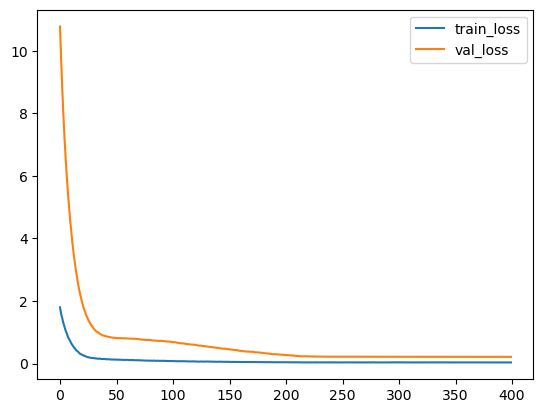

In [476]:
plt.plot(train_loss_per_epoch)
plt.plot(val_loss_per_epoch)
plt.legend(['train_loss','val_loss'])

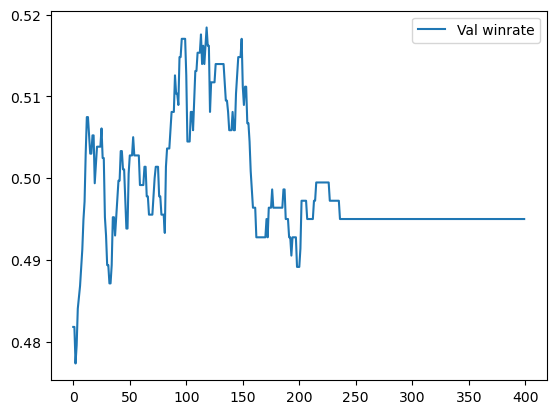

In [477]:
#plt.plot(train_winrate)
plt.plot(val_winrate)
plt.legend(['Val winrate'])

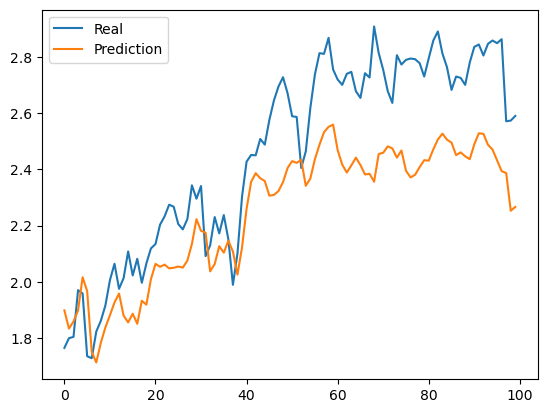

In [478]:
plt.plot(y_val[:100])
plt.plot(predictions1[:100])
plt.legend(['Real','Prediction'])

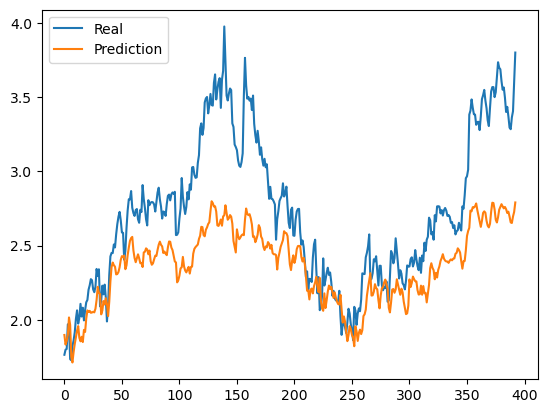

In [479]:
plt.plot(y_val)
plt.plot(predictions1)
plt.legend(['Real','Prediction'])

In [316]:
torch.save(model.state_dict(), f'ВЕСА/(ЛУКОЙЛ)(256,4,4,0.1)TRANS(ENC)(U) 1D|W=0.5586, VL=0.0600' )

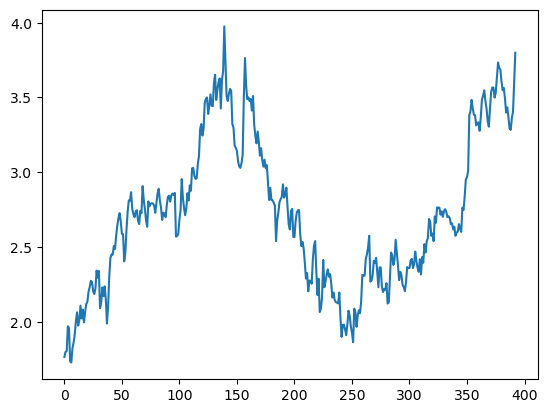

In [464]:
plt.plot(y_val)